## Comparing networks

Quantitatively measuring the similarity (or distance) between two networks is useful for comparing structure in spatial data. As with comparing numbers and vectors, there exist many metrics that quantify the similarity of networks that focus on specific features of the networks (local topology, global topology, metadata embedding). However, as networks contain more information than simple numbers and vectors (relational information), their comparative metrics need to be treated with a little more care as not all network distance metrics are well defined for any two networks. A good introduction to these concepts for those that work in biological sciences can be found [here](https://doi.org/10.1371/journal.pone.0228728).

A fundamental notation that defines two classes of network metrics is node-correspondence. Simply put, two networks $G_{1}$ and $G_{2}$ have node-correspondence if they have the same nodes in both networks and are indexed identically. In our case, this means we used the same objects to construct the two networks. Node-correspondence means we can directly compare the edge structure of the two networks and typically means metrics that use this feature are more efficient and are more easily interpreted. 

Node-correspondence is not usually a property we have when wanting to compare networks, but there are many other metrics out there we can use that do not require this. MuSpAn currently contains a selection of various network distance metrics (that we outline below) but this will grow as MuSpAn develops!


| Metric Name              | Metric Identifier       | Requires Node Correspondence | Description                                                                 |
|--------------------------|-------------------------|---------------------|-----------------------------------------------------------------------------|
| Euclidean                | `euclidean`             | Yes                  | Computes the Euclidean distance between the adjacency matrices of the two networks|
| Manhattan                | `manhattan`             | Yes                  | Computes the Manhattan distance between the adjacency matrices of the two networks           |
| Edit Distance            | `edit`                  | No                 | Counts the minimum number of operations required to transform one network into another. |
| DeltaCon                 | `deltacon_0`            | No                  | Measures the similarity between two networks based on their structure at multiple scales.      |
| NetLSD                   | `netlsd`                | No                  | Uses the Laplacian Spectral Descriptor to compare the global structure of networks. |
| k-Spectral Laplacian     | `k spectral laplacian`  | No                  | Compares networks based on the first k eigenvalues (smallest) of their Laplacian matrices.     |
| k-Spectral Adjacency     | `k spectral adjacency`  | No                  | Compares networks based on the last k eigenvalues (largest) of their adjacency matrices.     |
| Wasserstein Weisfeiler-Lehman (WLL) Kernel    | `wwl kernel`            | No                  | Uses both local structures and node labels to compare networks.    |

We recommend users familiarise themselves with the network distance metric before applying it in their spatial data analysis.



### Setting up a domain

We'll start this tutorial by loading in our usual imports and the `Synthetic-Points-Architecture` domain.

MuSpAn domain loaded successfully. Domain summary:
Domain name: Architecture
Number of objects: 5991
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []


(<Figure size 1620x1080 with 2 Axes>, <Axes: >)

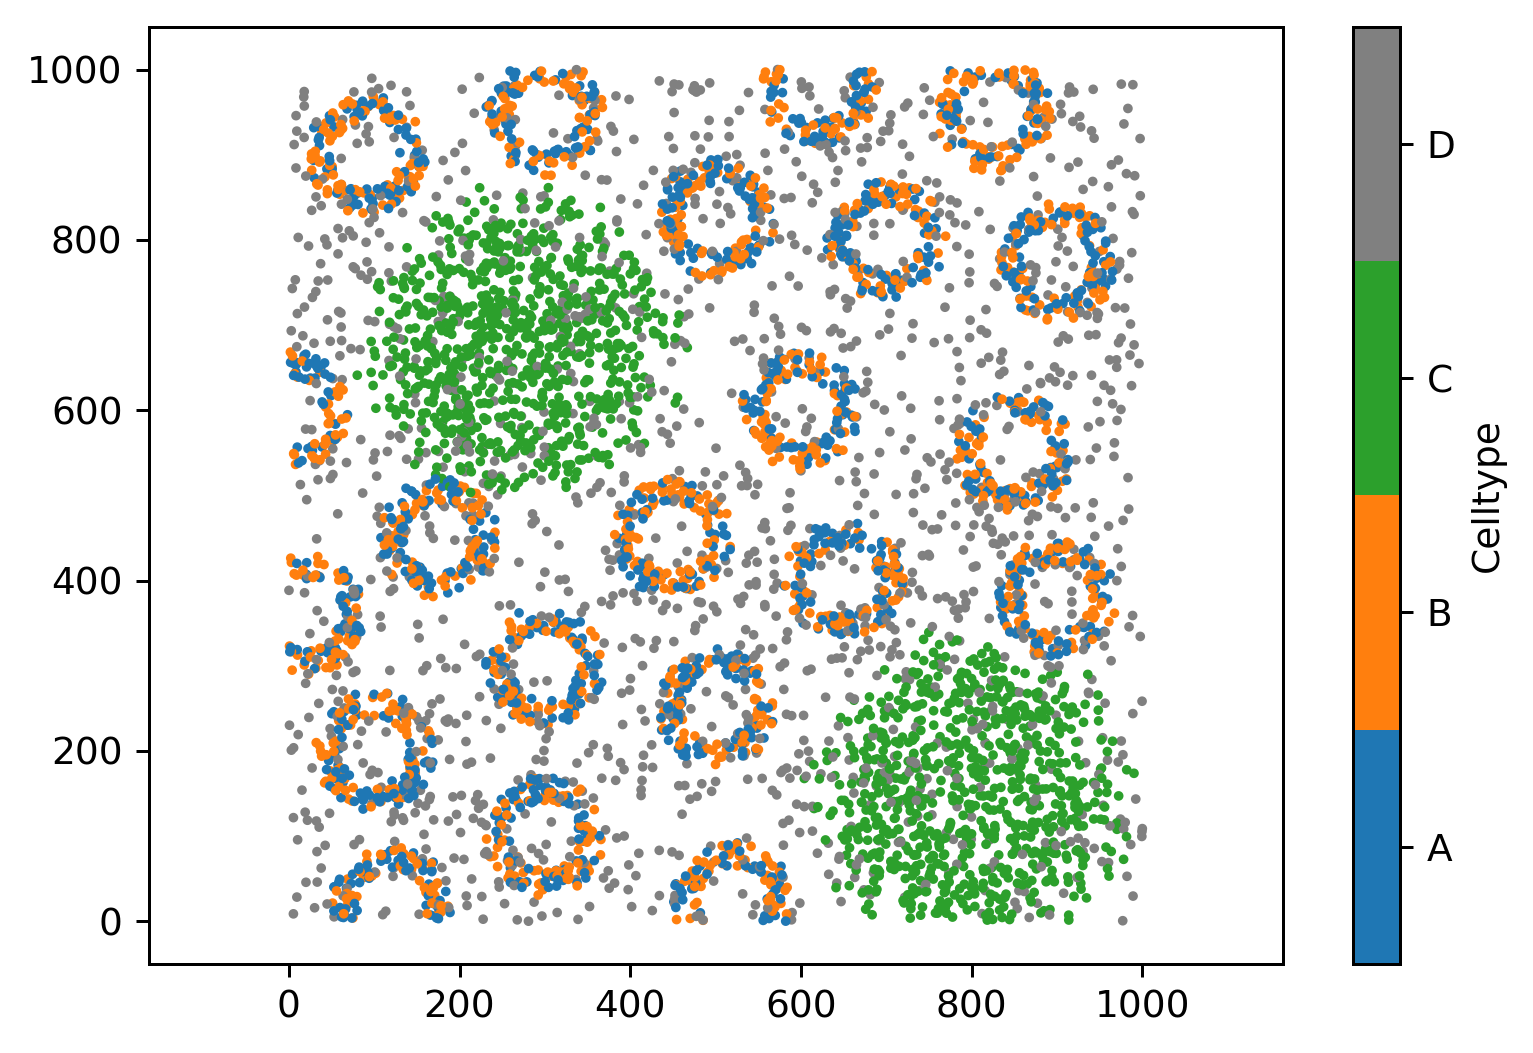

In [1]:
# Import necessary libraries
import muspan as ms 
import matplotlib.pyplot as plt

# Set the resolution for matplotlib figures
plt.rcParams['figure.dpi'] = 270

# Load the example domain 'Synthetic-Points-Architecture'
arch_domain = ms.datasets.load_example_domain('Synthetic-Points-Architecture')

# Visualise the architecture domain, coloring by 'Celltype'
ms.visualise.visualise(
    arch_domain, 
    color_by='Celltype', 
    figure_kwargs={'figsize': (6, 4)}, 
    marker_size=2.5
)

### Comparing networks with node-correspondence

To show how to compare networks that have the node-correspondence properties, we will build three networks on the same nodes but vary the edge structure. Let's build these networks using the `Proximity` method and increase the `max_edge_distance` for each.  

(<Figure size 5940x1620 with 4 Axes>,
 <Axes: title={'center': 'Proximity network: 100μm max distance'}>)

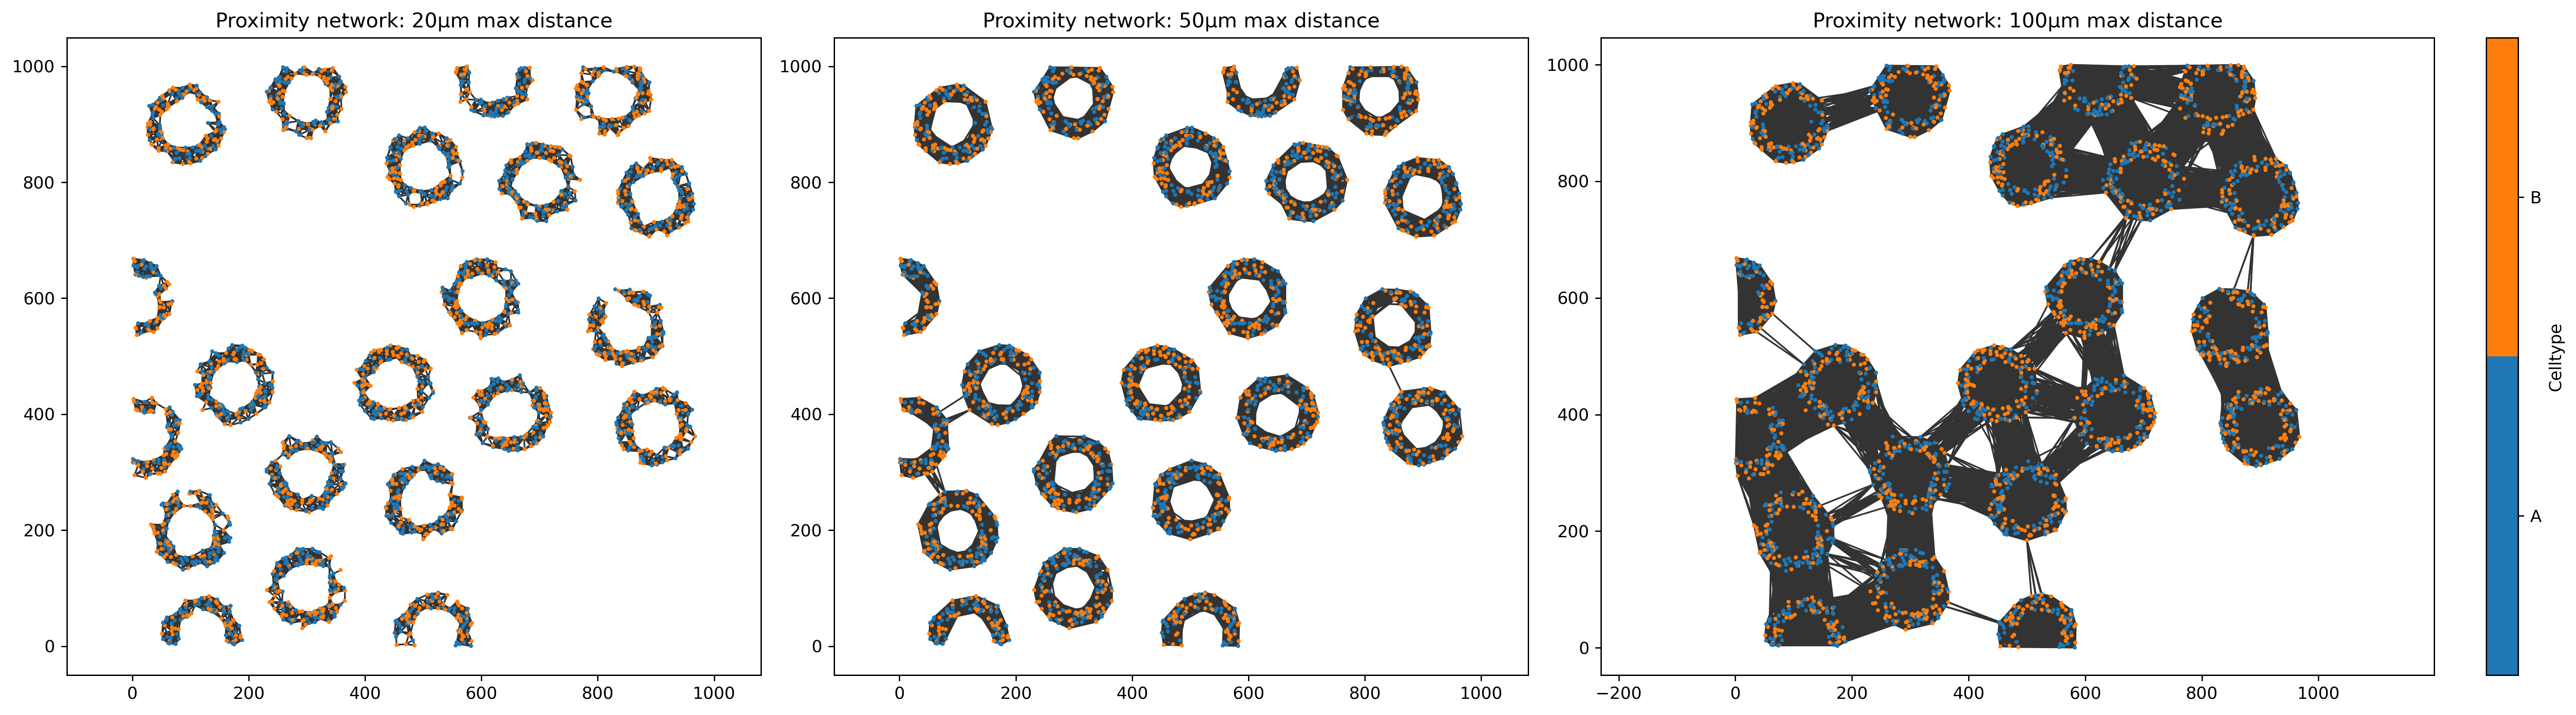

In [2]:
# Query points with labels A or B
query_ab = ms.query.query(arch_domain, ('label', 'Celltype'), 'in', ['A', 'B'])

# Generate proximity networks with different maximum edge distances
ms.networks.generate_network(
    arch_domain, 
    network_name='AB prox 20', 
    objects_as_nodes=query_ab, 
    network_type='proximity', 
    min_edge_distance=0, 
    max_edge_distance=20
)
ms.networks.generate_network(
    arch_domain, 
    network_name='AB prox 50', 
    objects_as_nodes=query_ab, 
    network_type='proximity', 
    min_edge_distance=0, 
    max_edge_distance=50
)
ms.networks.generate_network(
    arch_domain, 
    network_name='AB prox 100', 
    objects_as_nodes=query_ab, 
    network_type='proximity', 
    min_edge_distance=0, 
    max_edge_distance=100
)

# Visualise the generated networks
fig, ax = plt.subplots(1, 3, figsize=(22, 6), gridspec_kw={'width_ratios': [1, 1, 1.5]})

# Visualise the proximity network with 20μm max distance
ax[0].set_title('Proximity network: 20μm max distance')
ms.visualise.visualise_network(
    arch_domain, 
    network_name='AB prox 20', 
    ax=ax[0], 
    edge_cmap='viridis', 
    edge_vmin=0, 
    edge_vmax=100, 
    visualise_kwargs=dict(color_by='Celltype', objects_to_plot=query_ab, marker_size=2, add_cbar=False)
)

# Visualise the proximity network with 50μm max distance
ax[1].set_title('Proximity network: 50μm max distance')
ms.visualise.visualise_network(
    arch_domain, 
    network_name='AB prox 50', 
    ax=ax[1], 
    edge_cmap='viridis', 
    edge_vmin=0, 
    edge_vmax=100, 
    visualise_kwargs=dict(color_by='Celltype', objects_to_plot=query_ab, marker_size=2, add_cbar=False)
)

# Visualise the proximity network with 100μm max distance
ax[2].set_title('Proximity network: 100μm max distance')
ms.visualise.visualise_network(
    arch_domain, 
    network_name='AB prox 100', 
    ax=ax[2], 
    edge_cmap='viridis', 
    edge_vmin=0, 
    edge_vmax=100, 
    visualise_kwargs=dict(color_by='Celltype', objects_to_plot=query_ab, marker_size=2)
)

We'll now use the `Euclidean` metric to compare each of the these networks using the `muspan.networks.network_distance` function. To use this function, we require the networks themselves, not the names of the networks. **Importantly** this allows use to compare networks from different domains. Let's pull these out first:

In [3]:
# Extract the generated proximity networks from the architecture domain
net_prox_20 = arch_domain.networks['AB prox 20']
net_prox_50 = arch_domain.networks['AB prox 50']
net_prox_100 = arch_domain.networks['AB prox 100']

We have everything we need to compute the distances between these networks

In [4]:
# Compute the Euclidean distance between the same network (should be zero)
net_dist_20_20 = ms.networks.network_distance(
    net_prox_20, net_prox_20, weight_A='Distance', weight_B='Distance', distance_metric='euclidean'
)

# Compute the Euclidean distance between the proximity network with 20μm max distance and 50μm max distance
net_dist_20_50 = ms.networks.network_distance(
    net_prox_20, net_prox_50, weight_A='Distance', weight_B='Distance', distance_metric='euclidean'
)

# Compute the Euclidean distance between the proximity network with 20μm max distance and 100μm max distance
net_dist_20_100 = ms.networks.network_distance(
    net_prox_20, net_prox_100, weight_A='Distance', weight_B='Distance', distance_metric='euclidean'
)

# Print the computed distances
print('Distance between networks: AB prox 20 - AB prox 20 =', net_dist_20_20)
print('Distance between networks: AB prox 20 - AB prox 50 =', net_dist_20_50)
print('Distance between networks: AB prox 20 - AB prox 100 =', net_dist_20_100)

Distance between networks: AB prox 20 - AB prox 20 = 0.0
Distance between networks: AB prox 20 - AB prox 50 = 10449.711969156955
Distance between networks: AB prox 20 - AB prox 100 = 38344.67148306586


Though we have used the `Euclidean` metric that requires node-correspondence, we could have used any other metric in outlined in the above table. In addition, we could use any edge weight defined on each network, which would also alter our interpretation of the distance.

### Comparing networks without node-correspondence

If we want to compare two networks defined on different sets of nodes, we can use any other of the metric that do not require node-correspondence. To demonstrate this, we can load in two example domains that exhibit very different spatial structure and generate delaunay networks using the same parameters for both.

MuSpAn domain loaded successfully. Domain summary:
Domain name: Density
Number of objects: 2000
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []
MuSpAn domain loaded successfully. Domain summary:
Domain name: Architecture
Number of objects: 5991
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []


(<Figure size 2700x1350 with 2 Axes>,
 <Axes: title={'center': 'Architecture domain'}>)

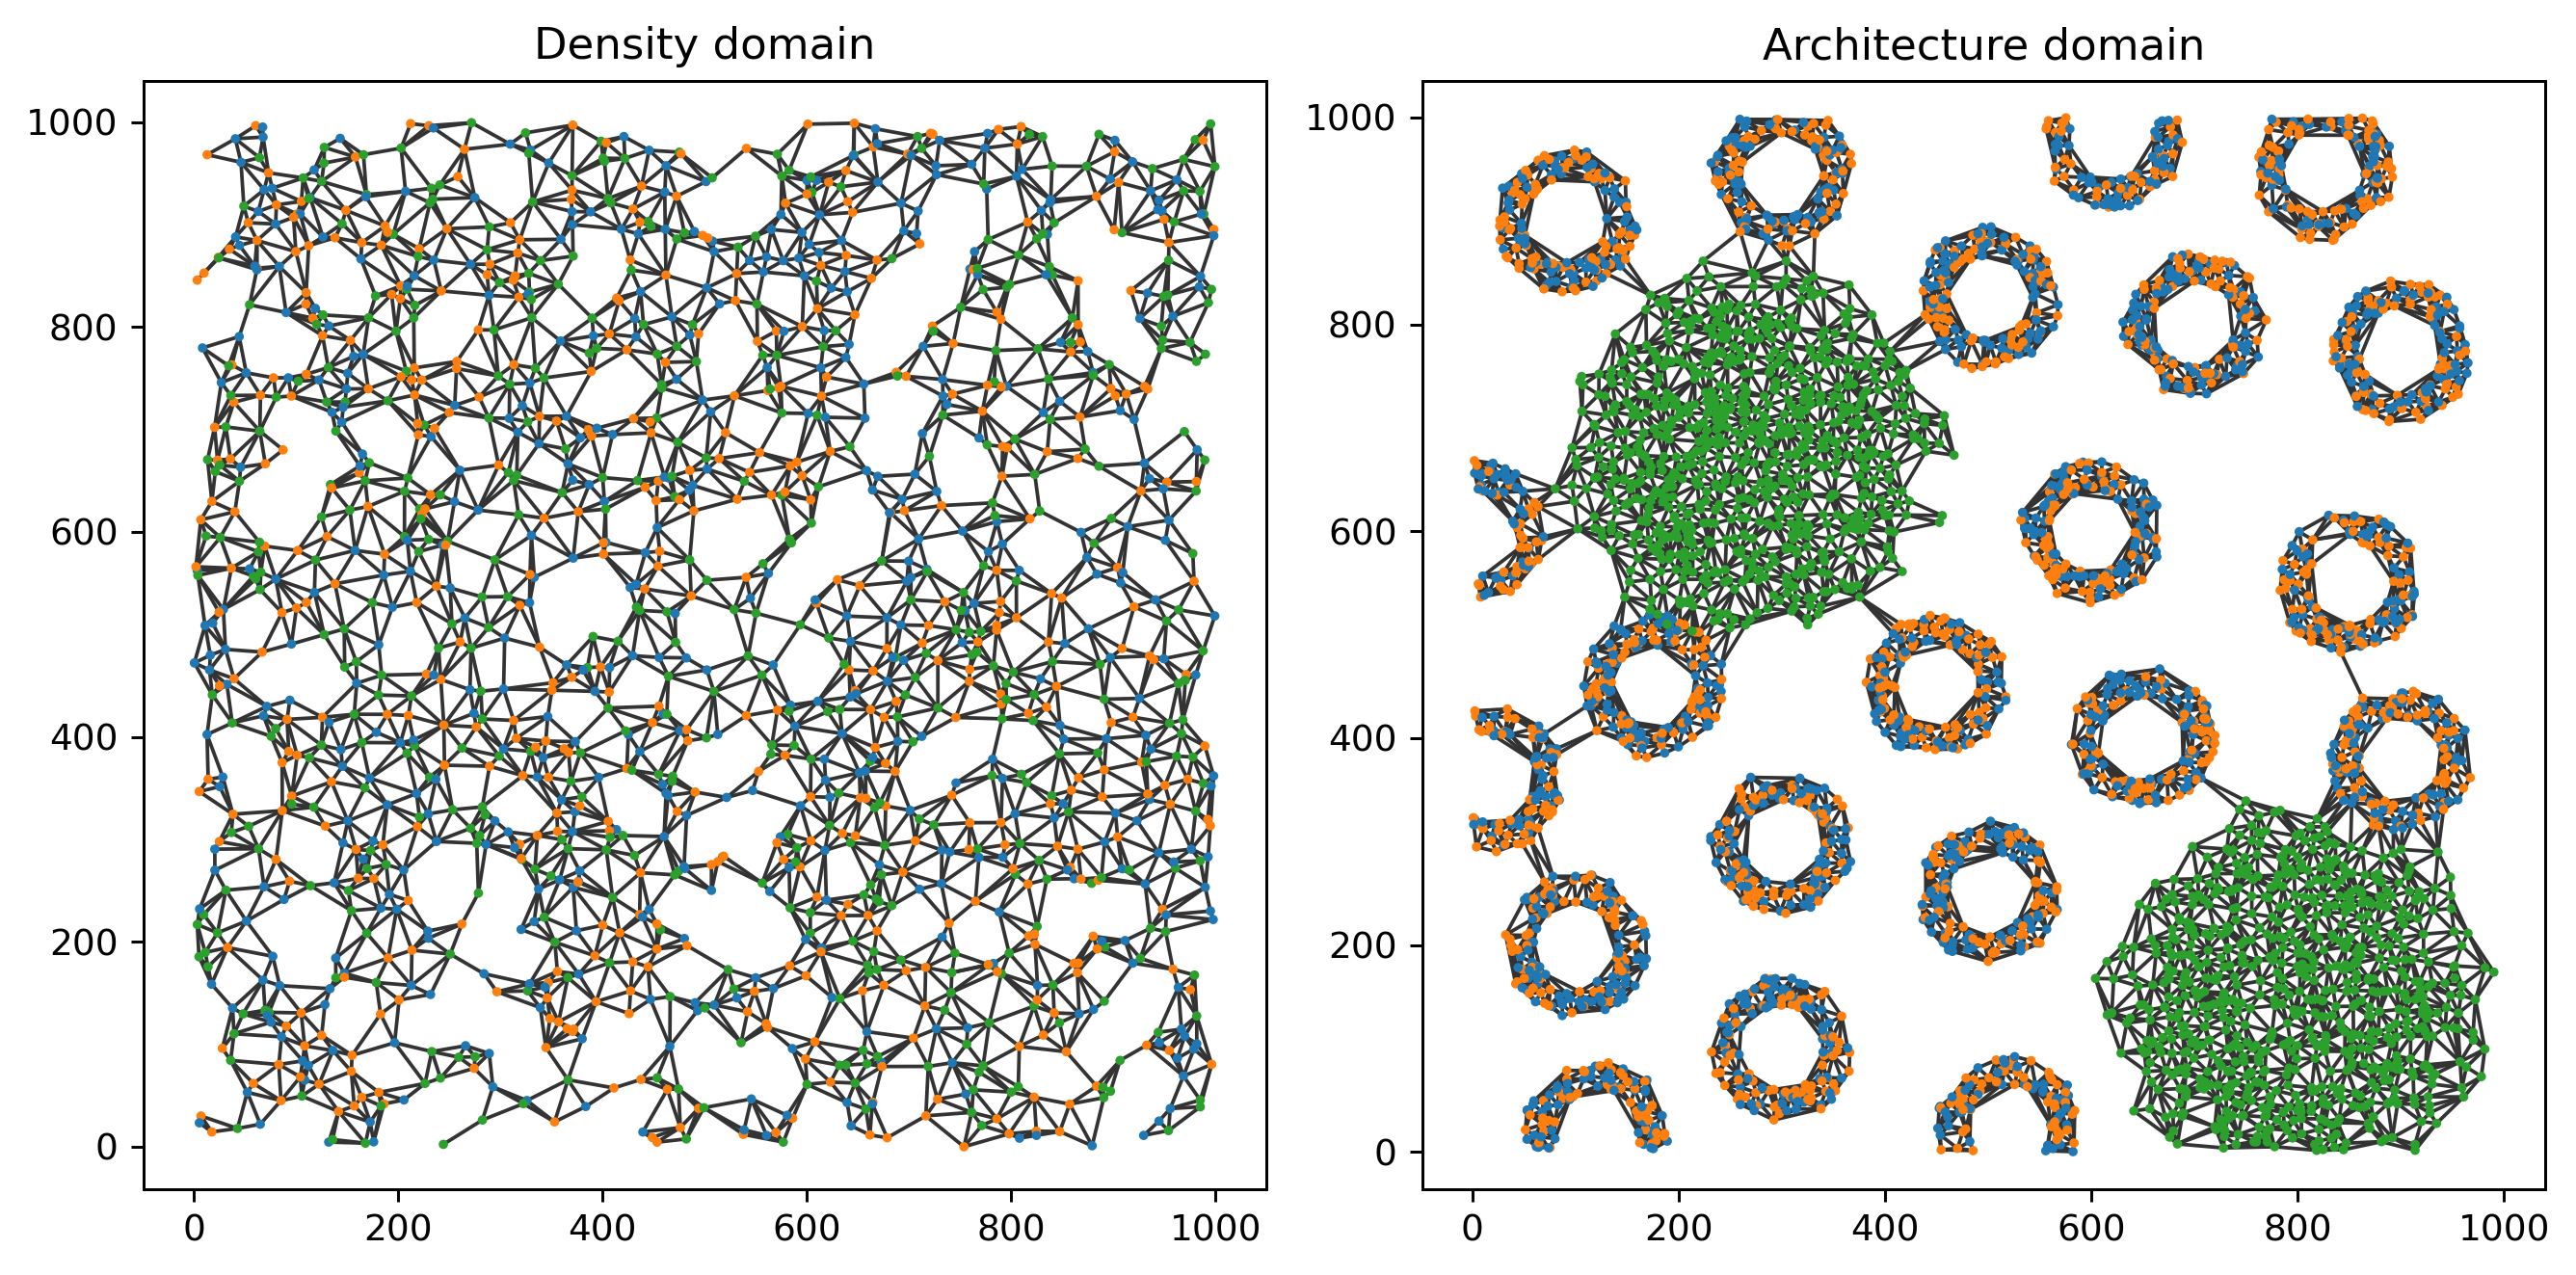

In [5]:
# Load example domains: Synthetic-Points-Random and Synthetic-Points-Architecture
noise_domain = ms.datasets.load_example_domain('Synthetic-Points-Random')
arch_domain = ms.datasets.load_example_domain('Synthetic-Points-Architecture')

# Query points with labels A, B, or C in both domains
query_abc_arch = ms.query.query(arch_domain, ('label', 'Celltype'), 'in', ['A', 'B', 'C'])
query_abc_noise = ms.query.query(noise_domain, ('label', 'Celltype'), 'in', ['A', 'B', 'C'])

# Generate Delaunay networks for both domains with a maximum edge distance of 50
noise_net = ms.networks.generate_network(
    noise_domain, 
    network_name='Density network', 
    objects_as_nodes=query_abc_noise, 
    network_type='delaunay', 
    min_edge_distance=0, 
    max_edge_distance=50
)
arch_net = ms.networks.generate_network(
    arch_domain, 
    network_name='Arch network', 
    objects_as_nodes=query_abc_arch, 
    network_type='delaunay', 
    min_edge_distance=0, 
    max_edge_distance=50
)

# Plot the generated networks for both domains
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the Density domain network
ax[0].set_title('Density domain')
ms.visualise.visualise_network(
    noise_domain, 
    network_name='Density network', 
    ax=ax[0], 
    visualise_kwargs=dict(objects_to_plot=query_abc_noise, color_by='Celltype', marker_size=2.5, add_cbar=False)
)

# Plot the Architecture domain network
ax[1].set_title('Architecture domain')
ms.visualise.visualise_network(
    arch_domain, 
    network_name='Arch network', 
    ax=ax[1], 
    visualise_kwargs=dict(objects_to_plot=query_abc_arch, color_by='Celltype', marker_size=2.5, add_cbar=False)
)

We can compute distances between these networks using various metrics via the `metrics` argument in the `muspan.networks.network_distance` function. Let's try this using the range of spectral distances we currently in MuSpAn.

In [6]:
# Compute the k-Spectral Laplacian distance between the noise and architecture networks
net_dist_k_lap = ms.networks.network_distance(
    noise_net, arch_net, 
    weight_A='Distance', weight_B='Distance', 
    distance_metric='k spectral laplacian', distance_kwargs=dict(k=20)
)

# Compute the k-Spectral Adjacency distance between the noise and architecture networks
net_dist_k_eig = ms.networks.network_distance(
    noise_net, arch_net, 
    weight_A='Distance', weight_B='Distance', 
    distance_metric='k spectral adjacency', distance_kwargs=dict(k=20)
)

# Compute the NetLSD distance between the noise and architecture networks
net_dist_netlsd = ms.networks.network_distance(
    noise_net, arch_net, 
    weight_A='Distance', weight_B='Distance', 
    distance_metric='netlsd',distance_kwargs=dict( netlsd_time=1, netlsd_timestep=0.2)
)

In [7]:
print('Distance between networks: Arch network - Noise network =',net_dist_k_lap)
print('Distance between networks: Arch network - Noise network =',net_dist_k_eig)
print('Distance between networks: Arch network - Noise network =',net_dist_netlsd)

Distance between networks: Arch network - Noise network = 0.06551147224633276
Distance between networks: Arch network - Noise network = 365.0456915993501
Distance between networks: Arch network - Noise network = 4780.440092346564


Critically, we should see that the metrics that account for global structural properties should produce larger distances. In the case of spectral metrics, this means increasing k for the time for heatflow in the `netlsd` metric. We can check this is the case below

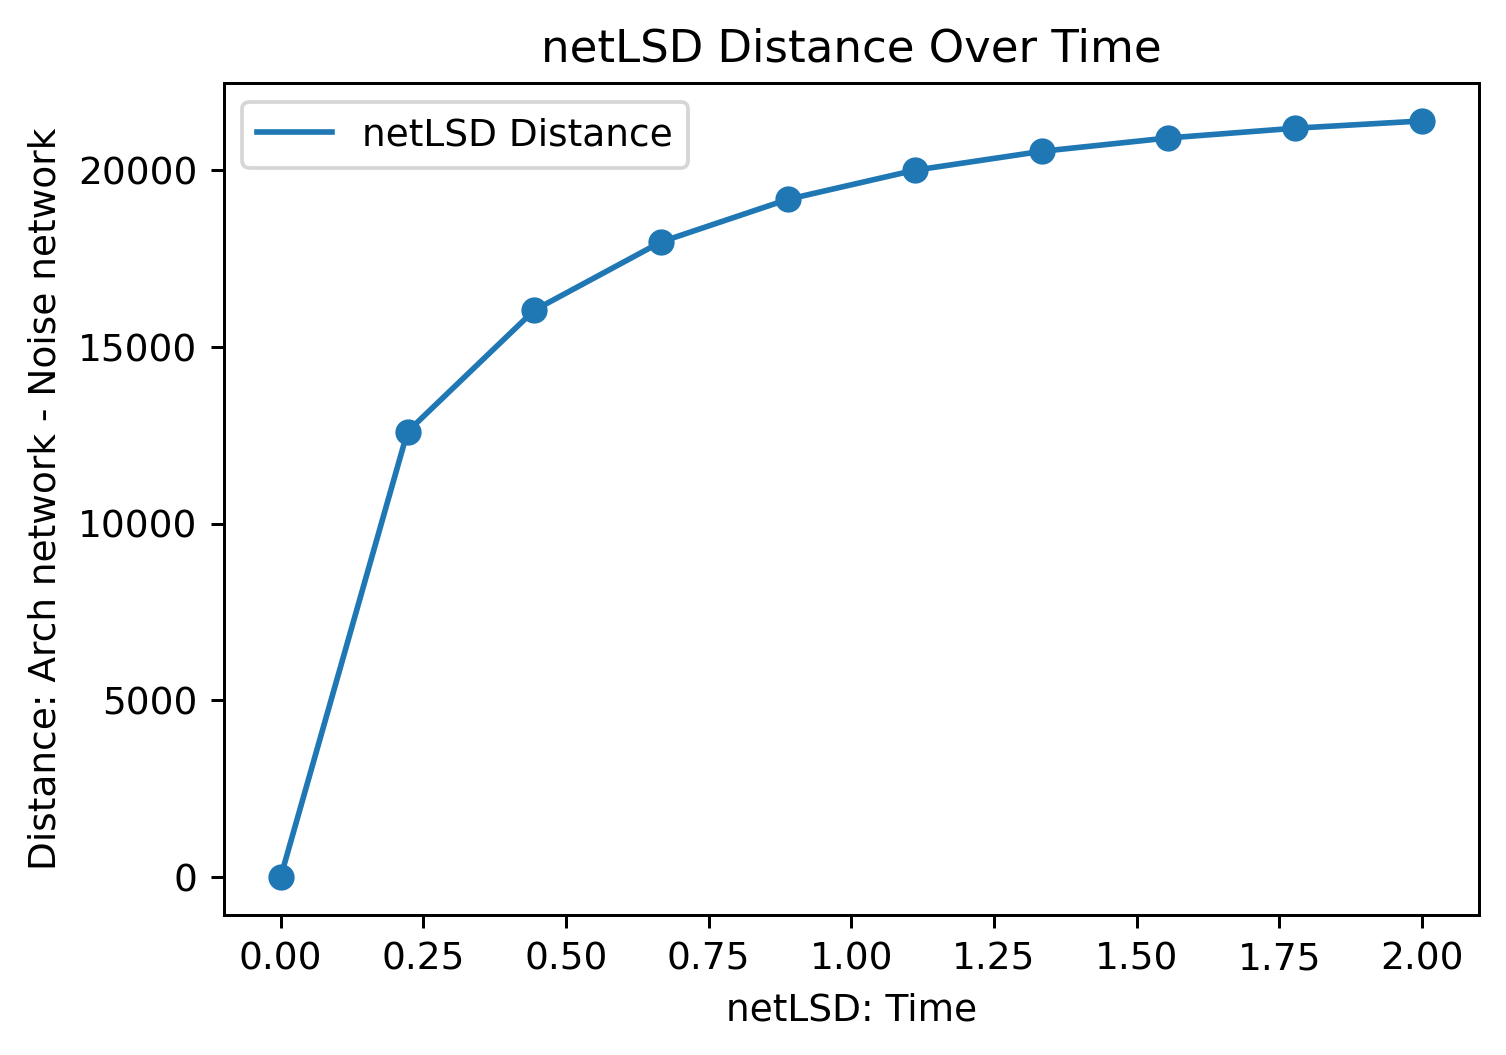

In [8]:
# Import necessary library
import numpy as np

# Initialize an empty list to store network distances
network_distances_net_lsd = []

# Define the time range for netLSD
time = np.linspace(0, 2, 10)

# Compute the netLSD distance for different time points
for i in time:
    distance = ms.networks.network_distance(
        noise_net, arch_net, 
        weight_A='Distance', weight_B='Distance', 
        distance_metric='netlsd', distance_kwargs=dict(netlsd_time=i, netlsd_timestep=0.01)
    )
    network_distances_net_lsd.append(distance)

# Plot the netLSD distances over time
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(time, network_distances_net_lsd, label='netLSD Distance')
ax.scatter(time, network_distances_net_lsd)
ax.set_xlabel('netLSD: Time')
ax.set_ylabel('Distance: Arch network - Noise network')
ax.set_title('netLSD Distance Over Time')
ax.legend()
plt.show()

These distances do not mean much without some context, so it's usually a good idea to normalise these against some known or baseline distance when using networks distances in spatial analysis.

**!WARNING!** Some network distance metrics scale very poorely with number of nodes and edges in each graph. Notably, the graph edit distance (`edit`) is a NP-hard problem, and therefore should only be used on small networks. For large networks, k spectral methods are usually efficient and suitable to detect structural changes. 

### Using kernels for label data embedding when comparing networks

The Wasserstein Weisfeiler-Lehman (WWL) kernel is a specific network distance metric that uses both the local structures and node labels to compare networks by iteratively averaging node label values of adjacent nodes, homogenising node features on the each network independently. After this process, the modified label spaces of each network is compared using a Wasserstein distance. For more information on the WWL kernel, see [this paper](https://arxiv.org/abs/1906.01277).

We can see this homogenising label interaction effect by increasing the number of `wwl iterations`:

In [9]:
# Initialize an empty list to store WWL distances
wwl_distance = []

# Define the range for WWL iterations
wwl_iterations = range(1, 11)

# Calculate the distance between the noise and architecture networks using the WWL kernel
for it in wwl_iterations:
    distance = ms.networks.network_distance(
        noise_net, arch_net, 
        weight_A=None, weight_B=None, 
        distance_metric='wwl kernel', 
        distance_kwargs=dict(wwl_iterations=it, wwl_label_features=['Celltype'], wwl_domains=[noise_domain, arch_domain])
    )
    wwl_distance.append(distance)

Text(0.5, 1.0, 'WWL Distance Over Iterations')

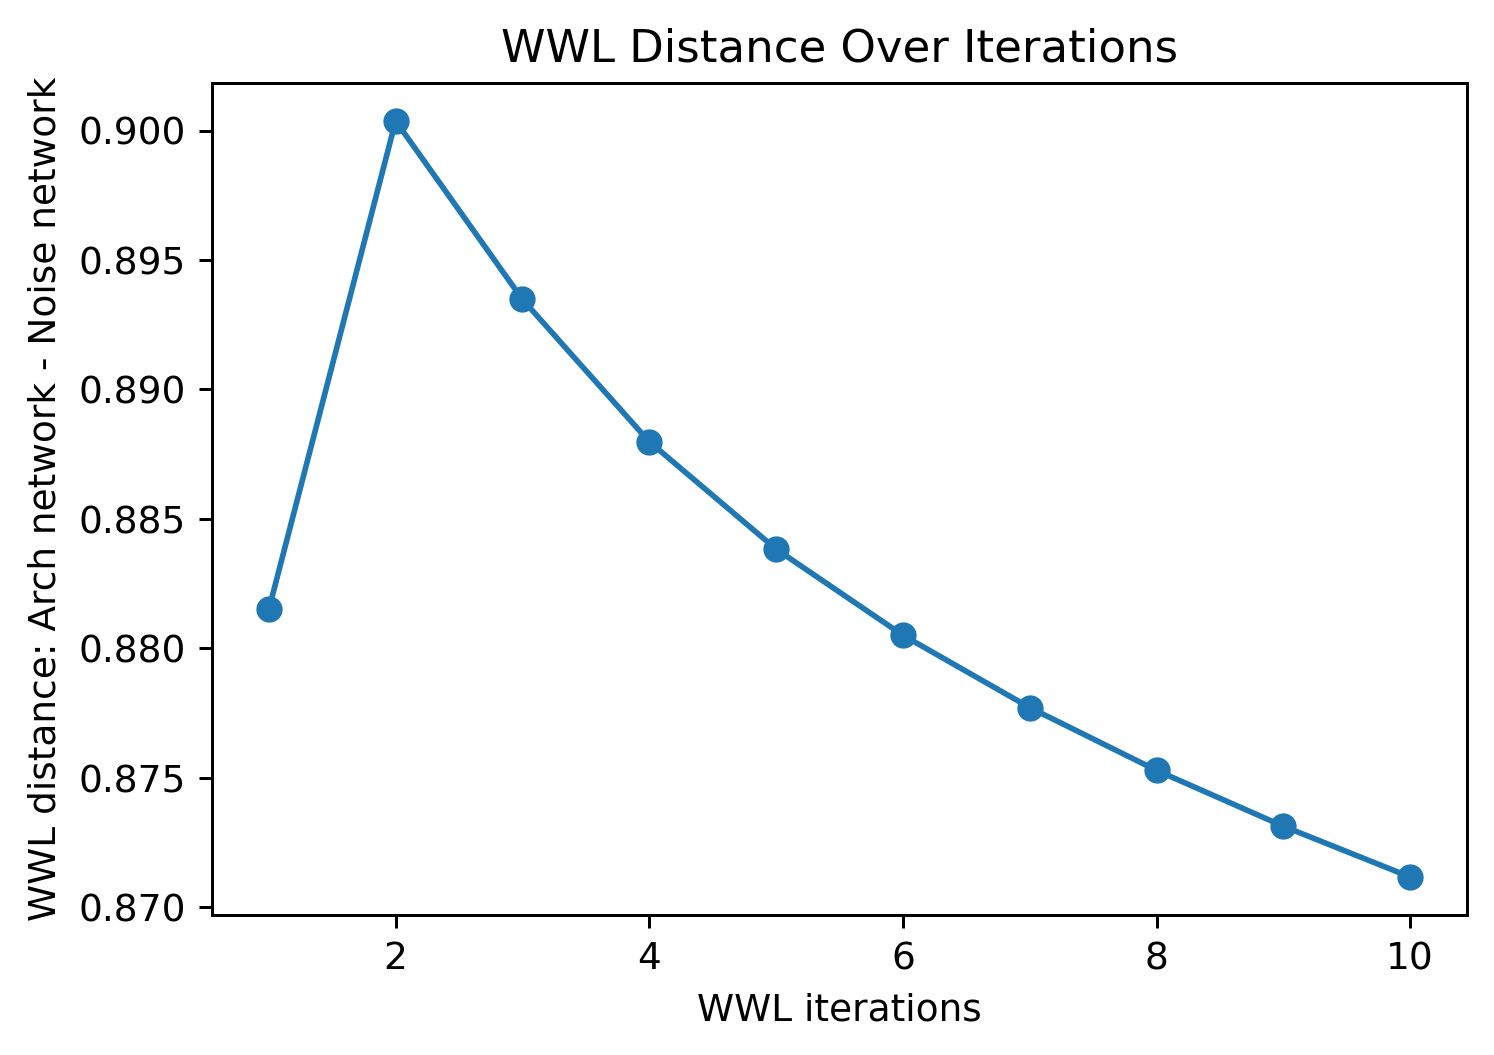

In [10]:
# Plot the WWL distances over different iterations
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot the WWL distance as a line plot
ax.plot(wwl_iterations, wwl_distance, label='WWL Distance')

# Add scatter points to the plot
ax.scatter(wwl_iterations, wwl_distance)

# Set the labels
ax.set_xlabel('WWL iterations')
ax.set_ylabel('WWL distance: Arch network - Noise network')

# Add a title to the plot
ax.set_title('WWL Distance Over Iterations')



### Importance of Choosing the Right Metrics

Choosing the right network distance metric is crucial for accurately capturing the features of the networks being compared. Different metrics focus on different aspects of network structure:

- **Node-Correspondence Metrics**: Metrics like Euclidean and Manhattan require node-correspondence and are efficient for comparing networks with the same nodes.
- **Structure Metrics**: Metrics like NetLSD and k-Spectral methods capture global structural properties and are suitable for detecting large-scale differences between networks.
- **Local Structure and Label Embedding Metrics**: The WWL kernel considers both local structures and node labels, making it ideal for comparing networks with rich node metadata.
